# Playground Competition Season 04 Episode 03
Here I will investigate depth and width of the NN. From the previous, 001, I have gotten 'Vanilla' scores that serve as a reference for improvement.

| Model       | Focus area             | Submitted AUC score |
|-------------|------------------------|---------------------|
| Vanilla 0.1 | None                   | 0.54859             |
| Vanilla 0.2 | Standardize input data | 0.57534             |
| Vanilla 0.3 | Re-sampling data       | 0.49236             |
| Lemon   1.0 | Default 3-layers       | 0.85335             |

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')

# Seperate X,y
prediction_categories = train_data.columns.drop(test_data.columns)
X_full = train_data.drop(prediction_categories, axis=1)
y_full = train_data[prediction_categories].copy()
assert(X_full.shape[1] == test_data.shape[1])

# Lemon 1.0, Adding flavour
I will build a function to build a model of various depth and width, then investigate how this model will perform.

In [2]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2)
X_test = test_data.copy()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pick columns with a 'large' mean, 
# I will chose 2.5 just to avoid manipulation the Log-based categories
cols_to_std = [c for c in X_train.columns if X_train[c].mean() > 2.5]

# Bundle preprocessing for numerical and categorical data
my_preprocessor = ColumnTransformer(
    transformers=[
        ('large mean', StandardScaler(), cols_to_std),
    ])
X_train[cols_to_std] = my_preprocessor.fit_transform(X_train)
X_valid[cols_to_std] = my_preprocessor.transform(X_valid)
X_test[cols_to_std] = my_preprocessor.transform(test_data)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

num_classes = y_train.shape[1]
num_features = X_train.shape[1]

def get_model(learning_rate=0.3,layers=[64,32,16]) -> Sequential:
    # Create a Sequential model
    model = Sequential()
    model.add(Input(shape=(num_features,)))
    #model.add(Dense(units=128,activation='relu'))
    for n in layers:
        model.add(Dense(units=n,activation='relu'))
        
    model.add(Dense(units=num_classes, activation='softmax'))
    #model.layers[0].input_shape = (num_features,)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
                  metrics=['accuracy','auc'])

    # Name the model
    model.name = 'Lemon' 
    return model
model = get_model()
# Print model summary
model.summary()

2024-03-02 23:33:44.003096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 23:33:44.003249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 23:33:44.163027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "Lemon"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,519 (17.65 KB)

 Trainable params: 4,519 (17.65 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
def get_early_stopping(patience=25,min_delta=0.001) -> EarlyStopping:
    return EarlyStopping(monitor='val_loss',
                         patience=patience, 
                         min_delta=min_delta,
                         restore_best_weights=True,
                         verbose=0,
                        )

# Helper func to display metrics from training history
def print_metrics(history) -> None:
    idx = np.argmin(history.history['val_loss'])
    print(f'Epochs until mest result: {idx}')
    print(f'Best validation accuracy: {history.history["val_accuracy"][idx]}')
    print(f'Best validation auc     : {history.history["auc"][idx]}')
    print(f'Best validation loss    : {history.history["val_loss"][idx]}')
    
# Helper func to plot metrics from training history
def plot_metrics(history,start=1) -> None:
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    history_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot loss and val_loss
    loss_plot = history_df.loc[start:, ['loss', 'val_loss']].plot(ax=axes[0], title="Categorical Cross-Entropy")
    loss_plot.set_xlabel("Epoch")

    # Plot accuracy and val_accuracy
    accuracy_plot = history_df.loc[start:, ['accuracy', 'val_accuracy']].plot(ax=axes[1], title="Accuracy")
    accuracy_plot.set_xlabel("Epoch")

    # Plot auc and val_auc
    auc_plot = history_df.loc[start:, ['auc', 'val_auc']].plot(ax=axes[2], title="AUC")
    auc_plot.set_xlabel("Epoch")

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

In [6]:
def train_model(model,verbose=0):
    early_stopping = get_early_stopping()
    
    history = model.fit(
        X_train,y_train,
        validation_data=(X_valid,y_valid),
        batch_size=512,
        epochs=200,
        callbacks=[early_stopping],
        verbose=verbose
    )

    return model,history

## Lemon 1.0
For 1.0 I will simply run the default model parameters and evaluate its score.

In [7]:
# Get a new model, although keep the learning rate at 0.0001
model = get_model(learning_rate=0.0001)
print(f'New model: {model.name}')
# Train the model
model,history = train_model(model)

New model: Lemon


Epochs until mest result: 78
Best validation accuracy: 0.540062427520752
Best validation auc     : 0.9057976603507996
Best validation loss    : 1.0026283264160156


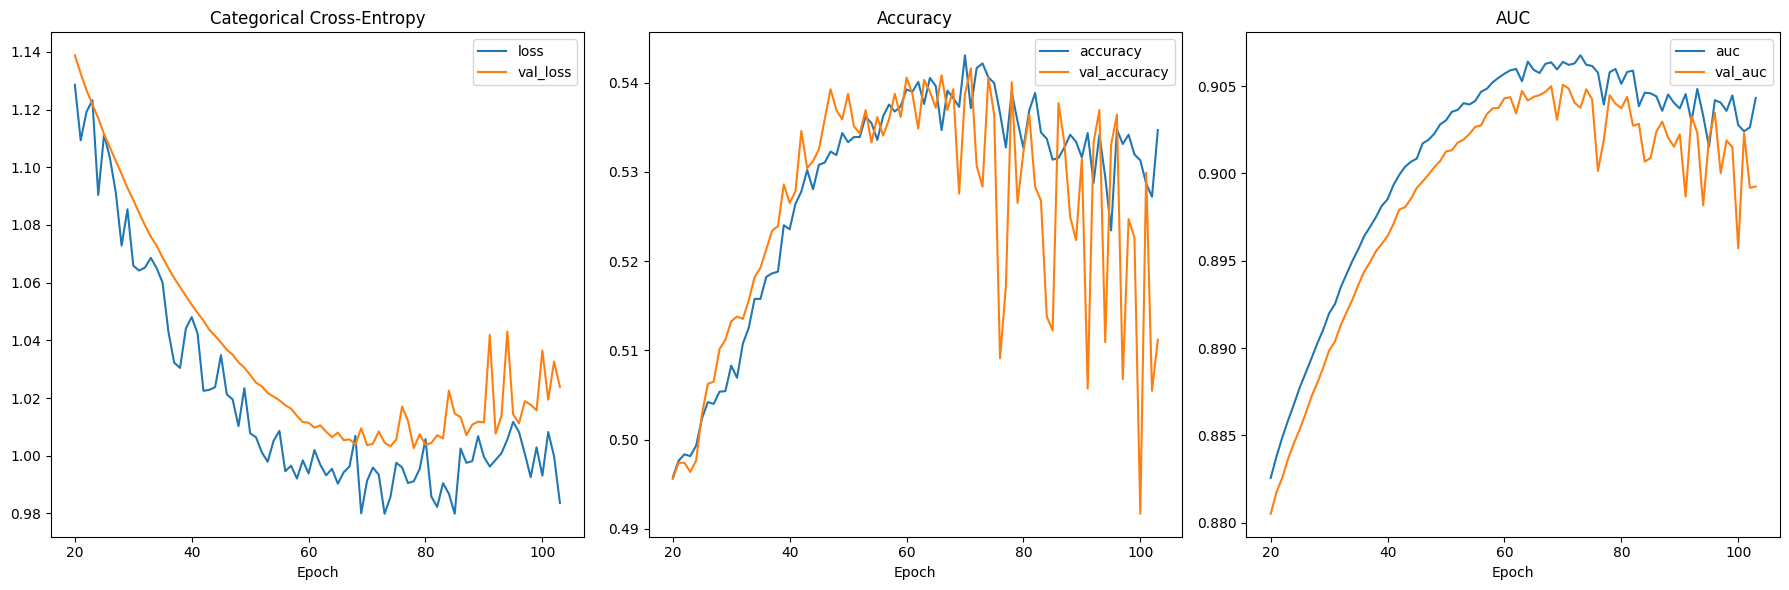

In [8]:
# Plot the metrics
print_metrics(history)
plot_metrics(history,start=20)

### Conclusion
Looking at AUC there is a big bump up from the vanilla model. 

In [9]:
# Train and submit
X_test = test_data
X_test[cols_to_std] = my_preprocessor.transform(test_data)
y_hat = model.predict(X_test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [10]:
output = pd.DataFrame(y_hat, columns=y_train.columns, index=test_data.index)
print(output.head())
output.to_csv('submission_lemon_004.csv', index=True)

         Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
id                                                                    
19219  0.242234   0.002866  0.005421  0.001320   0.023843  0.228452   
19220  0.205407   0.043081  0.037272  0.030551   0.109723  0.232368   
19221  0.020461   0.025504  0.052557  0.078588   0.034909  0.291510   
19222  0.098920   0.017502  0.001297  0.003413   0.016876  0.455574   
19223  0.018646   0.006144  0.001624  0.003419   0.008776  0.591189   

       Other_Faults  
id                   
19219      0.495864  
19220      0.341599  
19221      0.496473  
19222      0.406419  
19223      0.370202  
